# Don't Run All! - run only needed section at a time

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import serial
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set seed for reproducibility
def seed_all(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [120]:
# Format: Object-Distance-Height
class_names = ["Coin-10cm-10cm", "Coin-10cm-30cm", "Coin-30cm-10cm", "Coin-30cm-30cm",
               "Eraser-10cm-10cm", "Eraser-10cm-30cm", "Eraser-30cm-10cm", "Eraser-30cm-30cm"]

In [121]:
adc_threshold = 1000  # ADC threshold to start data collection
num_items_to_collect = 500  # Number of ADC values to collect
class_label = class_names.index("Coin-10cm-10cm")  # Class label for the current data collection
filepath = "data.csv"  # Name of the CSV file to save the data

# Data Collection

## Modify ```# Parameters```

In [ ]:
# Parameters
adc_threshold = 1000  # ADC threshold to start data collection
num_items_to_collect = 1000  # Number of ADC values to collect
class_label = class_names.index("Coin-10cm-10cm")  # Class label for the current data collection
filepath = "data.csv"  # Name of the CSV file to save the data

# Initialize serial communication
ser = serial.Serial(port="COM8", baudrate=230400, timeout=1)  # Configure the serial port
ser.flush()  # Flush the serial buffer to clear any existing data


# Function to read ADC value from the serial port
def read_adc_value():
    """
    Reads a single ADC value from the serial port.
    Returns:
        int: The ADC value if successfully read, otherwise None.
    """
    try:
        if ser.in_waiting > 0:  # Check if data is available in the serial buffer
            line = ser.readline().decode('utf-8').strip()  # Read and decode the line
            return int(line)  # Convert the line to an integer
    except ValueError:
        # Ignore invalid data that cannot be converted to an integer
        pass
    return None


# Function to save collected data to a CSV file
def save_to_csv(data, label, filepath):
    """
    Saves the collected data to a CSV file.
    Args:
        data (list): The list of collected ADC values.
        label (int): The class label for the data.
        filepath (str): The name of the CSV file to save the data.
    """
    # Add the new row to the dataframe
    df.loc[len(df)] = [label] + data
    # Save the dataframe to a CSV file
    df.to_csv(filepath, index=False)


# Read existing CSV file if it exists, otherwise create a new dataframe
try:
    df = pd.read_csv(filepath)  # Try to read the existing CSV file
except FileNotFoundError:
    # Create a new dataframe with appropriate columns if the file doesn't exist
    df = pd.DataFrame(columns=["label"] + ["data" + str(i + 1) for i in range(num_items_to_collect)])

# Data collection process
data = []  # List to store collected ADC values

try:
    print("Data collection started...")
    activated = False  # Flag to indicate if the threshold has been crossed

    # Collect data until the required number of items is reached
    while len(data) < num_items_to_collect:
        adc_value = read_adc_value()  # Read an ADC value
        if adc_value is not None:
            if not activated and adc_value > adc_threshold:
                # Start collecting data only after the threshold is crossed
                activated = True
                print("Threshold crossed. Collecting data...")
            if activated:
                # Append the ADC value to the data list
                data.append(adc_value)

    print("Data collection completed.")
except KeyboardInterrupt:
    # Handle manual interruption (Ctrl+C)
    print("Data collection interrupted.")
except Exception as e:
    # Handle any other exceptions
    print(f"An error occurred: {e}")

# Save the collected data to a CSV file
if data:
    save_to_csv(data, class_label, filepath)  # Save the data with the class label
    print("Data saved to CSV.")
else:
    print("No data collected.")

# Close the serial port
ser.close()

In [123]:
# Test
n = 10
df = pd.read_csv("data.csv")
data = df.iloc[n - 1, 1:].values  # Extract the latest data values (excluding the label column)
class_label = df.iloc[n - 1, 0]  # Extract the latest label (first column)

## Plot the latest data

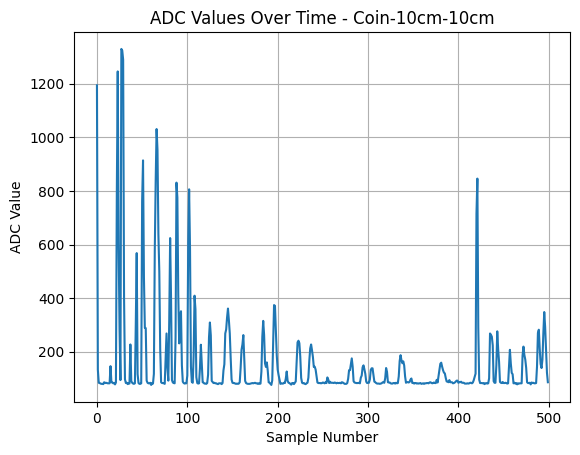

In [124]:
plt.plot(range(len(data)), data)  # Plot the ADC values
plt.xlabel("Sample Number")  # Label for the x-axis
plt.ylabel("ADC Value")  # Label for the y-axis
plt.title(f"ADC Values Over Time - {class_names[class_label]}")  # Title of the plot
plt.grid()  # Show grid lines on the plot
plt.show()  # Display the plot

# Fourier Transform
[Credit](https://www.youtube.com/watch?v=s2K1JfNR7Sc)

## For the latest data

### Compute the Fast Fourier Transform (FFT) and plot the Power Spectral Density (PSD)

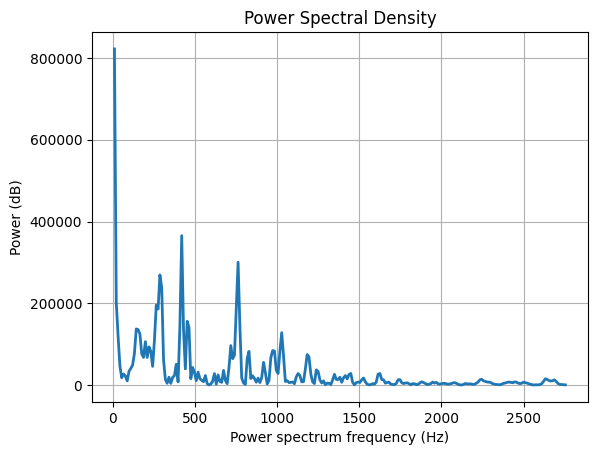

In [125]:
fs = 5530  # Sampling frequency in Hz

n = len(data)  # Number of samples

# Compute the FFT and Power Spectral Density (PSD)
fhat = np.fft.fft(data, n)
PSD = fhat * np.conj(fhat) / n
freq = (1 / (n * (1 / fs))) * np.arange(n)  # Frequency bins
L = np.arange(1, np.floor(n / 2), dtype='int')  # Positive frequencies

# Plot the Power Spectral Density
plt.plot(freq[L], PSD[L].real, linewidth=2)
plt.xlabel('Power spectrum frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Power Spectral Density')
plt.grid()
plt.show()

### Use the PSD to filter out noise

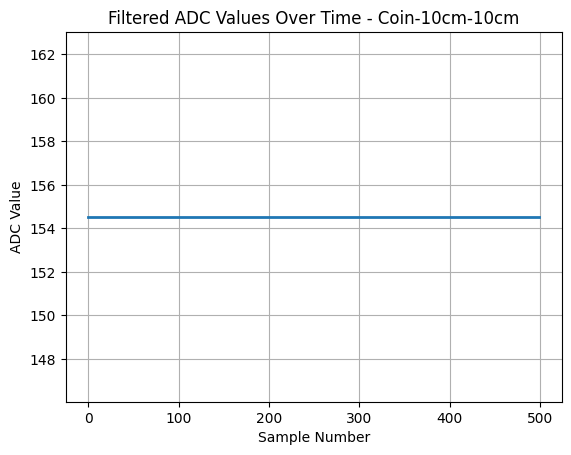

In [126]:
# Threshold the PSD to isolate significant frequencies
indices = PSD > 0.1 * np.max(PSD)  # Thresholding condition
fhat = fhat * indices     # Clean Fourier coefficients

# Inverse FFT to reconstruct the filtered signal
ffilt = np.fft.ifft(fhat).real  # Ensure real output

# Apply DC offset so the minimum value is 0
ffilt = ffilt + abs(min(0, np.min(ffilt)))

# Plot the filtered time-domain signal
plt.plot(range(len(data)), ffilt, linewidth=2)
plt.xlabel('Sample Number')
plt.ylabel('ADC Value')
plt.title(f"Filtered ADC Values Over Time - {class_names[class_label]}")
plt.grid()
plt.show()

## Fourier transform entire dataset for model training

In [157]:
def compute_psd(data):
    """
    Computes the Power Spectral Density (PSD) of the input signal.
    Args:
        data (array-like): Input time-domain signal.
    Returns:
        array: PSD of the input signal.
    """
    data = data - np.mean(data)  # Remove DC offset
    n = len(data)
    fhat = np.fft.fft(data, n)
    PSD = (fhat * np.conj(fhat)) / n
    return PSD[:n // 2].real  # Return only the positive frequencies
filepath = "data_testo.csv"
df = pd.read_csv(filepath)  # Read the existing CSV file

# Create a new DataFrame to store PSD-transformed data
psd_length = len(df.columns) - 1  # Same number of samples per row (excluding label)
df_psd = pd.DataFrame(columns=["label"] + [f"psd{i+1}" for i in range(psd_length // 2)])

for i in range(len(df)):
    label = int(df.iloc[i, 0])  # Extract and ensure label is int
    data = df.iloc[i, 1:].values.astype(float)  # Extract signal values
    psd = compute_psd(data)  # Compute PSD
    df_psd.loc[i] = [label] + list(psd)  # Assign to new DataFrame

# Convert the label column to integers
df_psd["label"] = df_psd["label"].astype(int)

# Save the PSD-transformed data to a new CSV file
filepath_psd = filepath.replace("data", "data_psd")
df_psd.to_csv(filepath_psd, index=False)


In [ ]:
# Plot a few samples before and after PSD
num_examples_to_plot = 72  # Number of examples you want to visualize

for i in range(num_examples_to_plot):
    label = int(df.iloc[i, 0])
    time_data = df.iloc[i, 1:].values.astype(float)
    psd_data = compute_psd(time_data)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Time-domain plot
    axs[0].plot(time_data, linewidth=1.5)
    axs[0].set_title(f"Time-Domain Signal (Label: {label})")
    axs[0].set_xlabel("Sample Number")
    axs[0].set_ylabel("Amplitude")
    axs[0].grid(True)

    # PSD plot
    axs[1].plot(psd_data, linewidth=1.5)
    axs[1].set_title(f"Power Spectral Density (Label: {label})")
    axs[1].set_xlabel("Frequency Bin")
    axs[1].set_ylabel("Power")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


# Train Classification Model

In [196]:
class PiezoDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.X = features
        self.y = labels
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.transform:
            x = self.transform(x)
        
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

In [197]:
# Assuming you have your data in a CSV file
df = pd.read_csv("data_psd.csv")  # Update with your dataset path

# Assuming your dataset has columns 'feature_1', 'feature_2', ..., 'feature_n' for the features and 'label' for the target
X = df.drop(columns=["label"]).values  # Features
y = df["label"].values  # Labels

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create PyTorch datasets
train_dataset = PiezoDataset(features=X_train, labels=y_train)
val_dataset = PiezoDataset(features=X_val, labels=y_val)

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [198]:
class PiezoNN(nn.Module):
    def __init__(self, input_size, num_classes, device='cpu'):
        super(PiezoNN, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(input_size, 512)  # Increase units in the first layer
        self.fc2 = nn.Linear(512, 256)         # Increase units in the second layer
        self.fc3 = nn.Linear(256, num_classes) # Output layer
        self.bn1 = nn.BatchNorm1d(512)         # Batch normalization after first layer
        self.bn2 = nn.BatchNorm1d(256)         # Batch normalization after second layer
        self.dropout = nn.Dropout(0.3)         # Dropout to prevent overfitting

    def forward(self, x):
        x = F.relu(self.fc1(x))  # ReLU activation after the first layer
        x = self.bn1(x)          # Batch Normalization
        x = F.relu(self.fc2(x))  # ReLU activation after the second layer
        x = self.bn2(x)          # Batch Normalization
        x = self.dropout(x)      # Apply dropout for regularization
        x = self.fc3(x)          # Output layer
        return x

    def train_model(self, epochs, optimizer, scheduler, train_loader, val_loader, verbose=True):
        self.loss_train_log = []
        self.loss_val_log = []
        self.best_loss = np.inf

        # Move model to device
        self.to(device=self.device)

        for epoch in range(epochs):
            self.train()
            for x, y in train_loader:
                x = x.to(device=self.device)
                y = y.to(device=self.device)

                optimizer.zero_grad()
                yhat = self.forward(x)
                loss = F.cross_entropy(yhat, y)
                loss.backward()
                optimizer.step()

            # Step the scheduler
            scheduler.step()

            # Calculate loss for training and validation sets
            loss_train = self.evaluate(train_loader)
            self.loss_train_log.append(loss_train)

            loss_val = self.evaluate(val_loader)
            self.loss_val_log.append(loss_val)

            if verbose:
                print(f'Epoch {epoch+1}/{epochs}: Train Loss = {loss_train:.4f}, Val Loss = {loss_val:.4f}')

            if loss_val < self.best_loss:
                self.best_loss = loss_val
                best_epoch = epoch + 1
                torch.save(self.state_dict(), "best_piezo_model.pt")

        print(f'Best model saved at epoch {best_epoch} with loss {self.best_loss:.4f}.')

    def evaluate(self, loader):
        self.eval()
        loss = 0
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device=self.device)
                y = y.to(device=self.device)
                yhat = self.forward(x)
                loss += F.cross_entropy(yhat, y, reduction='sum')
        
        loss /= len(loader.dataset)
        return loss.cpu()

    def predict(self, loader):
        self.eval()
        x_all, y_all, logit = [], [], []
        with torch.no_grad():
            for x, y in loader:
                x_all += [x]
                y_all += [y]
                x = x.to(device=self.device)  # Move data to the same device as model
                y = y.to(device=self.device)  # Move labels to the same device as model
                yhat = self.forward(x)
                logit.append(yhat.cpu())  # Move logits back to CPU for easier manipulation
                
            x_all, y_all, logit = torch.cat(x_all, dim=0), torch.cat(y_all, dim=0), torch.cat(logit, dim=0)
            return x_all, y_all, logit

In [199]:
# Model training
input_size = len(train_dataset[0][0])  # Number of features in your dataset
num_classes = len(np.unique(train_dataset.y))  # Number of unique labels
model = PiezoNN(input_size=input_size, num_classes=num_classes, device=device)

# Set up the optimizer and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Train the model
model.train_model(epochs=100, optimizer=optimizer, scheduler=scheduler, train_loader=train_loader, val_loader=val_loader)

Epoch 1/100: Train Loss = 1.0788, Val Loss = 1.2346
Epoch 2/100: Train Loss = 0.5608, Val Loss = 0.8202
Epoch 3/100: Train Loss = 0.3181, Val Loss = 0.5844
Epoch 4/100: Train Loss = 0.2020, Val Loss = 0.4496
Epoch 5/100: Train Loss = 0.1406, Val Loss = 0.3915
Epoch 6/100: Train Loss = 0.1111, Val Loss = 0.3674
Epoch 7/100: Train Loss = 0.0909, Val Loss = 0.3702
Epoch 8/100: Train Loss = 0.0747, Val Loss = 0.3455
Epoch 9/100: Train Loss = 0.0643, Val Loss = 0.3252
Epoch 10/100: Train Loss = 0.0533, Val Loss = 0.3100
Epoch 11/100: Train Loss = 0.0449, Val Loss = 0.3106
Epoch 12/100: Train Loss = 0.0383, Val Loss = 0.3127
Epoch 13/100: Train Loss = 0.0322, Val Loss = 0.3053
Epoch 14/100: Train Loss = 0.0283, Val Loss = 0.3082
Epoch 15/100: Train Loss = 0.0251, Val Loss = 0.3038
Epoch 16/100: Train Loss = 0.0217, Val Loss = 0.3060
Epoch 17/100: Train Loss = 0.0198, Val Loss = 0.3038
Epoch 18/100: Train Loss = 0.0184, Val Loss = 0.2993
Epoch 19/100: Train Loss = 0.0173, Val Loss = 0.2991
Ep

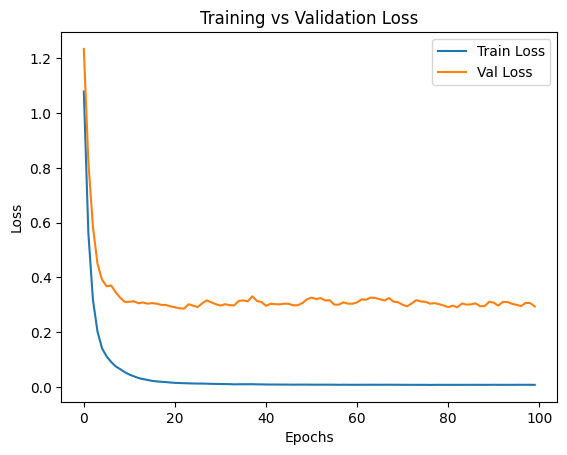

In [200]:
# Plotting training vs val loss
plt.plot(model.loss_train_log)
plt.plot(model.loss_val_log)
plt.legend(['Train Loss', 'Val Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')# Assuming you have your data in a CSV file
plt.title('Training vs Validation Loss')
plt.show()

In [201]:
# Load new test data
df_test = pd.read_csv("data_psd_test.csv")  # Update path if needed

# Extract features and labels
X_test_new = df_test.drop(columns=["label"]).values
y_test_new = df_test["label"].values

# Create dataset and dataloader
test_dataset_new = PiezoDataset(features=X_test_new, labels=y_test_new)
test_loader_new = DataLoader(test_dataset_new, batch_size=64, shuffle=False)

# Load the best model
best_params = torch.load('best_piezo_model.pt')
model_best = PiezoNN(input_size=input_size, num_classes=num_classes, device=device)
model_best.load_state_dict(best_params)
model_best.to(device)

# Evaluate on new test data
x_all, y_all, logit = model_best.predict(test_loader_new)
predictions = F.softmax(logit, dim=1).argmax(dim=1)
accuracy = (predictions == y_all).sum().item() / len(y_all)

print(f'Accuracy on new test data: {accuracy:.4f}')


Accuracy on new test data: 0.2000


# Evaluate Classification Model

# Demo Run